## Company Sentiment Analysis with Twitter (Part 1)

Author: [**Raffi Sahakyan**](https://www.linkedin.com/in/raffi-sahakyan)
MS in Business Aanlytics Candidate at UCLA Anderson

In partial collaboration with Paul Deitel,
as part of the Python Bootcamp session at UCLA Anderson. 

<hr style="height:2px; border:none; color:#000; background-color:#000;">

### Objectives
* **Data-mine Twitter** with **Tweepy** library
* Search **past tweets** with the **Twitter Search API**
* Use **NLP** to **clean and preprocess tweets** for analysis
* Perform **sentiment analysis** on tweets
* **Map tweets** using **folium** and **OpenStreetMap**

In [1]:
# Importing basic libraries
import pandas as pd
import matplotlib.pyplot as plt

# Twitter and Text Libraries
import tweepy
from textblob import TextBlob
import preprocessor as p  # p recommended by docs
from wordcloud import WordCloud

#Mapping libraries
import geopy
import folium

# Enable high-res images in notebook 
%config InlineBackend.figure_format = 'retina'

# Matplotlib show
%matplotlib inline

# Matplotliv styling
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

# Keys for Twitter API Access and Mapquest
import keys #keys.py file with your keys
consumer_key = 'crV7dU23FGGDYxRlh1YnPNDNp'
consumer_secret = 'Sr5FaWAEyKw82hoLuPDumOOyGcmvdP4SstYiOLi2imUrw3PJMb'
access_token = '1180669965235453952-XnpyHmkvMfJfflfr3MYpi30raL4ESs'
access_token_secret = '5Uepg4DoBAtsSKHLculQH6kn8UsVm5W4YpdZ4MMxLGw4n'
mapquest_key = 'VyEePwAhQZ9WkkAaYmIq62H6ELSM4Oi9'

For this project you will need to apply for [**Twitter**](https://developer.twitter.com/en/apply-for-access.html) and [**Mapquest**](https://developer.mapquest.com/) Developer Accounts

#### Asking for input

* Generally company name is preferred
* Yet, any string may be subject of search if interested

In [2]:
#Notably Python 3 replaced raw_input to input, so all type of inputs are acceptable
company_name = str(input())

 Nike


#### Authenticating with Twitter Via Tweepy
* **Authentication API**—Authenticate with your **Twitter credentials** to use other Twitter APIs
* **`keys.py`** must contain your credentials

In [3]:
auth = tweepy.OAuthHandler(consumer_key,
                           consumer_secret)
auth.set_access_token(access_token,
                      access_token_secret)

### Creating the Tweepy API Object
* A **Tweepy `API` object** is your **gateway** to Twitter APIs

In [4]:
api = tweepy.API(auth, wait_on_rate_limit=True, 
                 wait_on_rate_limit_notify=True)

* **`auth`** is the **`OAuthHandler`**
* **`wait_on_rate_limit=True`** &mdash; **wait 15 minutes** when app reaches an API method’s rate limit
    * prevents violations
* **`wait_on_rate_limit_notify=True`** &mdash; **display a command-line message** when you hit a rate limit

In [5]:
tweets = api.search(q = company_name, count = 1000) 
#Number of tweets can be modified, but in the process approximately half of the tweets are dropped 

In [6]:
def get_tweets(tweets, tweet_list):
    """For each Tweepy Status object in tweets check whether the tweet is in
    English and append to the list of the tweets"""
    for tweet in tweets:    
        if 'en' in tweet.lang:
            tweet_list.append(tweet)

In [7]:
tweet_list = []
get_tweets(tweets, tweet_list)

#### Cleaning/Preprocessing Tweets for Analysis
* **Data cleaning** is one of data scientists' most common tasks 
* Some **NLP tasks** for **normalizing tweets**
    * Converting text to **same case**
    * Removing **`#` from hashtags**, **`@`-mentions**, **duplicates**, **hashtags**
    * Removing **excess whitespace**, **punctuation**, **stop words**, **URLs**
    * Removing tweet keywords **`RT`** (retweet) and **`FAV`** (favorite) 
    * **Stemming** and **lemmatization**
    * **Tokenization**

<hr style="height:2px; border:none; color:#000; background-color:#000;">

### [**tweet-preprocessor**](https://github.com/s/preprocessor) Library and TextBlob Utility Functions
* `pip install tweet-preprocessor`
* Can automatically remove any combination of:

| Option	| Option constant
| :---	| :---
| **`OPT.MENTION`** | @-Mentions (e.g., `@nasa`)	
| **`OPT.EMOJI`** | Emoji	
| **`OPT.HASHTAG`** | Hashtag (e.g., `#mars`)	
| **`OPT.NUMBER`** | Number	
| **`OPT.RESERVED`** | Reserved Words (`RT` and `FAV`)	
| **`OPT.SMILEY`** | Smiley	
| **`OPT.URL`** | URL	

<hr style="height:2px; border:none; color:#000; background-color:#000;">

### Cleaning a Tweet Containing a Reserved Word and a URL
* The tweet-preprocessor library’s module name is **`preprocessor`** 

In [8]:
#Creating empty lists for function to store each part in the according list
user_list = []
text_list = []
polarity_list = []
location_list = []

p.set_options(p.OPT.URL, p.OPT.RESERVED, p.OPT.MENTION)  # specify what to clean

def get_tweet_content(tweet, location=False):
    """Return lists with data from tweet-Status object)."""
    try:  
        user_list.append(tweet.user.screen_name) # get the user's screen name
        text_list.append(p.clean(tweet.extended_tweet.full_text)) # get the tweet's text if full text is available
        
    except: 
        text_list.append(p.clean(tweet.text)) # get the tweet's text if full text is not available
        
    blob = TextBlob(tweet.text) # creating TextBlob object to check for polarity. 
    if blob.sentiment.polarity > 0: # Blob.sentiment.polarity returns a score is a float within the range [-1.0, 1.0].
        polarity_list.append('positive') 
    elif blob.sentiment.polarity == 0:
        polarity_list.append('neutral')
    else:
        polarity_list.append('negative')     

    if location:
        location_list.append(tweet.user.location) # Returns user's location, which may or may not be real, will be checked further

    return user_list, text_list, polarity_list, location_list

In [9]:
# Applying the get_tweet_content function to our list of tweets
for i in tweet_list:
    get_tweet_content(i, location=True)

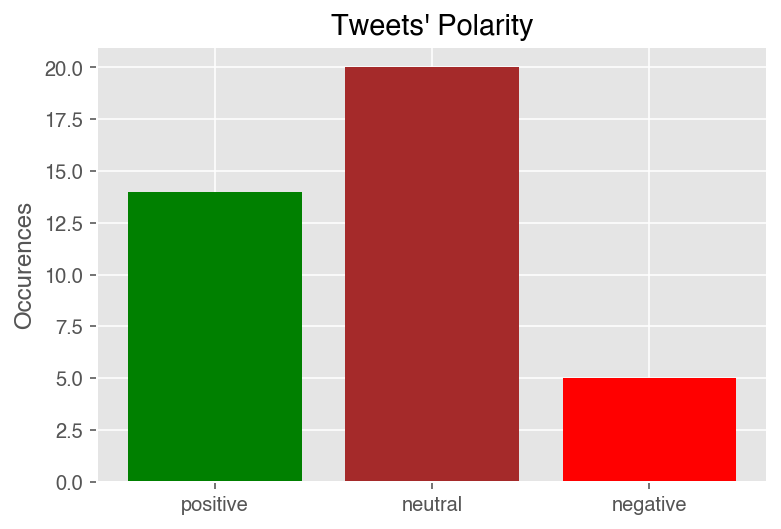

In [10]:
plt.bar(x = ['positive','neutral','negative'], 
        height = [polarity_list.count('positive'),polarity_list.count('neutral'),polarity_list.count('negative')], 
        color=['green', 'brown', 'red'])
plt.title("Tweets' Polarity")
plt.ylabel("Occurences")
plt.show()

#### Generating the Word Cloud, Saving It and Displaying It

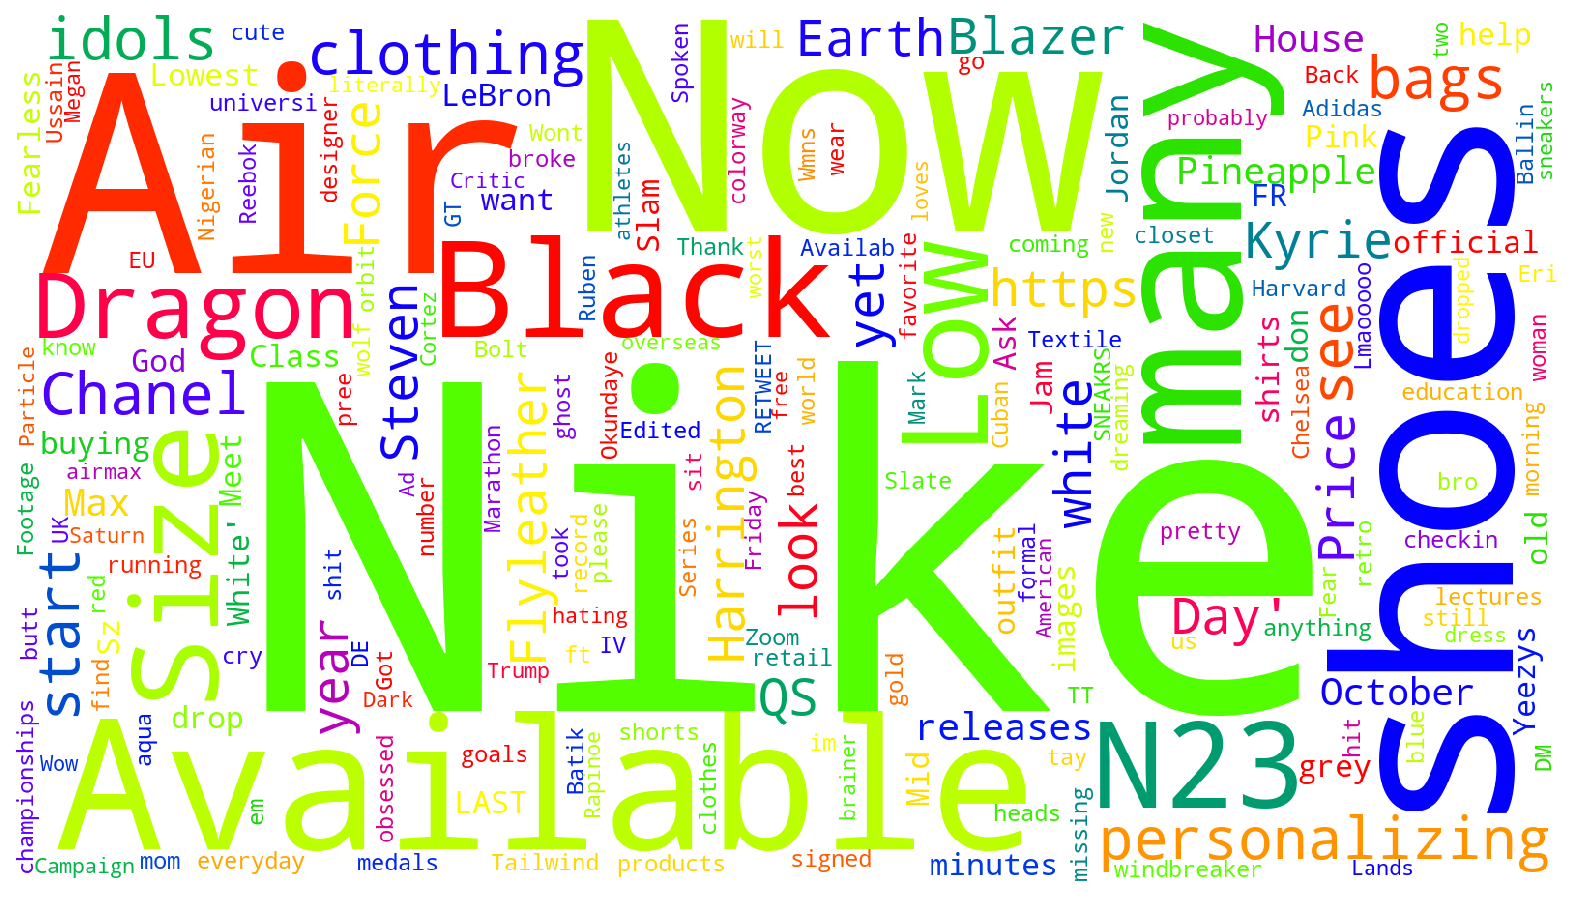

In [11]:
unique_string=(" ").join(text_list) #Taking each word in each tweet seperately

wordcloud = WordCloud(width=1600, height=900, prefer_horizontal=.5,
                     min_font_size=10, colormap='prism',
                     background_color='white', collocations=False).generate(unique_string)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("WordCloud"+".png", bbox_inches='tight')
plt.show()
plt.close()

#### Geocoding and Mapping
* **Plot** tweets' **locations** on an **interactive map**
* **Twitter disables precise location info (latitude/longitude) by default** (users must opt in to allowing Twitter to track locations) 
* Large percentage include the user’s home location information
    * Sometimes invalid or fictitious, which will be checked and dropped if necessary 
* **Map markers** will show `location` from each tweet’s `User` object

#### [**geopy** library](https://github.com/geopy/geopy)
* **Geocoding**&mdash;translate locations into **latitude** and **longitude**
* **geopy** supports dozens of **geocoding web services**, many with **free or lite tiers**
* We’ll use **OpenMapQuest geocoding service** 

#### OpenMapQuest Geocoding API
* Convert locations, such as **Boston, MA** into their **latitudes** and **longitudes**, such as **42.3602534** and **-71.0582912**, for plotting on maps
* Currently allows **15,000 transactions per month** on their free tier
* You can [sign up](https://developer.mapquest.com/) with this link

<hr style="height:2px; border:none; color:#000; background-color:#000;">

#### [**folium library**](https://github.com/python-visualization/folium) and Leaflet.js JavaScript Mapping Library
* Uses **Leaflet.js JavaScript mapping library** to display maps in a web page 
* Folium can output **HTML documents** for viewing in a **web browser**

<hr style="height:2px; border:none; color:#000; background-color:#000;">

#### Maps from OpenStreetMap.org
By default, **Leaflet.js** uses **open source maps** from **`OpenStreetMap.org`**
* To use these maps, **they require the following copyright notice**:

> `Map data © OpenStreetMap contributors`

* They also say: **You must make it clear that the data is available under the Open Database License. This can be achieved by providing a “License” or “Terms” link which links to https://www.openstreetmap.org/copyright or https://www.opendatacommons.org/licenses/odbl/index.html**

In [12]:
geo = geopy.OpenMapQuest(api_key=mapquest_key)  # geocoder, mapquest_key from keys.py
geo_location_list = [] #empty list to add locations
for i in location_list:
    geo_location_list.append(geo.geocode(i))

In [13]:
tweet_df = pd.DataFrame(data = {'Screen_name':user_list,'Tweet_text':text_list,'Polarity':polarity_list, 'Location':geo_location_list})
tweet_df.dropna(inplace=True)
tweet_df.head(3)

Screen_name                                         Tweet_text  \
0  ITSDJPRETTIBOI  : *Steven Harrington x Nike Air Force 1 Low Fl...   
2  ITSDJPRETTIBOI  : *Nike S.B Blazer Low GT Slate* Now available...   
4        docaga04  : Is this the best Nike Air Fear Of God 1 colo...   

   Polarity                                           Location  
0   neutral  (Events, Row E, Heigham Grove, Norwich, Norfol...  
2  positive  (Events, Row E, Heigham Grove, Norwich, Norfol...  
4  positive  (Manila, Metro Manila, Philippines, (14.597872...

### Creating a Map with Folium

In [14]:
usmap = folium.Map(location=[39.8283, -98.5795],  # center of U.S.
                   tiles='Stamen Terrain',
                   zoom_start=4, detect_retina=True)

* **`location`** &mdash; sequence containing **latitude** and **longitude** of **map center point**
    * [Geographic center of the continental United States](http://bit.ly/CenterOfTheUS) 
* **`zoom_start`** &mdash; **map’s initial zoom level**
* **`detect_retina`** &mdash; enables folium to use **higher-resolution maps**

<hr style="height:2px; border:none; color:#000; background-color:#000;">

### Creating Folium `Popup` Objects for the Tweet Locations
* **`itertuples`** creates **tuples** from **each row** of the **`DataFrame`**
* Each **tuple** contains a **property** for each **`DataFrame` column**

In [15]:
for t in tweet_df.itertuples():
    text = ': '.join([t.Screen_name, t.Tweet_text, t.Polarity])
    popup = folium.Popup(text)
    marker = folium.Marker((t.Location.latitude, t.Location.longitude), 
                           popup=popup)
    marker.add_to(usmap)

<hr style="height:2px; border:none; color:#000; background-color:#000;">

### Saving the Map with Map’s **`save`** Method 

In [16]:
usmap.save('tweet_map.html')

<hr style="height:2px; border:none; color:#000; background-color:#000;">

### Displaying the Map in Jupyter 
* The resulting map follows. 
<a href="./tweet_map.html">Interactive tweet map</a>

In [17]:
usmap

#### License and Diclaimer

The MIT License

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.